# Tutorial for the cluster weak lensing analysis

This is a tutorial for the weak lensing analysis of massive clusters of galaxies. Originally it was prepared for an online summer school organized by Institut Teknologi Bandung (ITB), Bandung, West Java, Indonesia, held in September 2020 (the webpage is [here](https://www.as.itb.ac.id/ssgc2020/)). 

The purpose of this tutorial is to learn the basics of the cluster weak lensing analysis, following the lecture given at the summer school. I derive a tangential shear profile from a shear catalog, and fit it to a model shear profile to derive cluster parameters such as the mass. The slides of my lecture is available [here](https://oguri.github.io/lectures/2020ssgc/ssgc2020.pdf). Key equations needed for the analysis are given in the slides.

## Data

In this tutorial I use weak lensing shape catalogs in cluster fields (catalogs of galaxies behind clusters with ellipticity measurements for each galaxy) presented in [Oguri et al. (2012)](https://ui.adsabs.harvard.edu/abs/2012MNRAS.420.3213O). In the paper weak lensing shape catalogs are derived for about 30 clusters based on Subaru Suprime-cam imaging data. Here I prepare shear catalogs for the following 8 clusters 

| cluster_name | redshift | center RA | center Dec |
|:---:|:---:|:---:|:---:|
|a1703    | 0.277 | 198.771833 | 51.817389 |
|gho1320  | 0.308 | 200.703208 | 31.654944 |
|sdss0851 | 0.370 | 132.911917 | 33.518361 |
|sdss1050 | 0.60  | 162.666250 |  0.285306 |
|sdss1138 | 0.451 | 174.537292 | 27.908528 |
|sdss1226 | 0.435 | 186.712958 | 21.831194 |
|sdss1329 | 0.443 | 202.393708 | 22.721167 |
|sdss1531 | 0.335 | 232.794167 | 34.240278 |

whose weak lensing signals are relatively more significant. In [data/](data/) there is the catalog named `shear_cluster_name.dat` for each cluster. In the file, each line corresponds to one galaxy and contains information on
```
RA Dec gamma1 gamma2 weight
```
note that `gamma1` and `gamma2` are defined in the coordinate system with +x direction being -RA and +y direction being +Dec.

## Getting started

First start with loading modules and define cosmological parameters

In [1]:
%matplotlib inline

import numpy as np
from astropy import wcs
from scipy.optimize import curve_fit
from astropy import constants as const
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from numpy.lib import scimath as sm
import matplotlib as mpl
import matplotlib.pyplot as plt

cosmo = FlatLambdaCDM(H0 = 70, Om0 = 0.3)

The basic parameters for the 8 clusters are also provided

In [2]:
clusters = ['a1703', 'gho1320', 'sdss0851', 'sdss1050', 'sdss1138', 'sdss1226', 'sdss1329', 'sdss1531']

zl_all = {'a1703': 0.277, 'gho1320': 0.308, 'sdss0851': 0.370, 'sdss1050': 0.60, 'sdss1138': 0.451, 'sdss1226': 0.435, 'sdss1329': 0.443, 'sdss1531': 0.335}

ra_cl_all = {'a1703': 198.771833, 'gho1320': 200.703208, 'sdss0851': 132.911917, 'sdss1050': 162.666250, 'sdss1138': 174.537292, 'sdss1226': 186.712958, 'sdss1329': 202.393708, 'sdss1531':  232.794167}

dec_cl_all = {'a1703': 51.817389, 'gho1320': 31.654944, 'sdss0851': 33.518361, 'sdss1050': 0.285306, 'sdss1138': 27.908528, 'sdss1226': 21.831194, 'sdss1329': 22.721167, 'sdss1531':  34.240278}

Let's see an example for the cluster `a1703` (you can check results for other clusters by changing `cname`)

In [57]:
cname   = 'sdss1138'

# cluster redshift
zl      = zl_all.get(cname)

# coordinates of the cluster center
ra_cl   = ra_cl_all.get(cname)
dec_cl  = dec_cl_all.get(cname)

# fix source redshift to 1.0
zs = 1.0

Note that the source redshift is used only for deriving a velocity dispersion of the cluster from tangential shear fitting (see below). 

## Deriving a tangential shear profile

First I need to read the shape catalog

In [58]:
rfile = 'data/shear_' + cname + '.dat'
data = np.loadtxt(rfile, comments = '#')

ra  = data[:, 0]
dec = data[:, 1]
g1  = data[:, 2]
g2  = data[:, 3]
wei = data[:, 4]

I start with converting RA and Dec to flat sky coordinate ($x = \theta_1$, $y = \theta_2$) centered at each cluster center. $x$ and $y$ are in units of arcmin. Note that -RA is $+x$ direction, following the definition of shear.

In [59]:
dx = -1.0 / 60.0
dy =  1.0 / 60.0

w = wcs.WCS(naxis = 2)

w.wcs.crval = [ra_cl, dec_cl]
w.wcs.cd    = np.array([[dx, 0.0], [0.0, dy]])
w.wcs.ctype = ['RA---TAN', 'DEC--TAN']
w.wcs.crpix = [0, 0]

coord = np.stack([ra, dec], axis = 1)
    
xy = w.wcs_world2pix(coord, 1)

x = xy[:,0]
y = xy[:,1]

In [60]:
wcs.WCS(naxis = 2)

WCS Keywords

Number of WCS axes: 2
CTYPE : ''  ''  
CRVAL : 0.0  0.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 1.0  1.0  
NAXIS : 0  0

In [61]:
xy

array([[  9.2140249 ,   0.53586269],
       [ 11.57545795,  -3.63458563],
       [ -9.65000898,   7.39814254],
       ...,
       [-11.11979322,  -3.47997904],
       [-16.87301776,   7.80418554],
       [ -8.7179132 ,  -8.41807659]])

We then the define the annulus i.e., $\theta$ bin. It is equally spaced in log10 between $10^{\rm ltmin}$ and $10^{\rm ltmax}$. I also derive $\theta$ for each galaxy

In [62]:
ltmin  =  0.0
ltmax  =  1.28
dlt    =  0.16

nbin = int((ltmax - ltmin + 1.0e-30) / dlt)

lt1 = np.linspace(ltmin, ltmax - dlt, num = nbin)
lt2 = np.linspace(ltmin + dlt, ltmax, num = nbin)

tbin = 10 ** (0.5 * (lt1 + lt2))

t  = np.sqrt(x * x + y * y)
lt = np.log10(t)

In [63]:
(lt1+lt2)*0.5

array([0.08, 0.24, 0.4 , 0.56, 0.72, 0.88, 1.04, 1.2 ])

In [64]:
lt2

array([0.16, 0.32, 0.48, 0.64, 0.8 , 0.96, 1.12, 1.28])

Now let's compute tangential and cross shear following the definition given in page 27 of [the slides](https://oguri.github.io/lectures/2020ssgc/ssgc2020.pdf)

In [65]:
cos2 = (x * x - y * y) / (t * t + 1.0e-30)
sin2 = 2.0 * x * y  / (t * t + 1.0e-30)

gt = (-1.0) * cos2 * g1 - sin2 * g2
gx = sin2 * g1 - cos2 * g2

Next I compute tangential and cross shear profiles and their errors following equations given in page 36 of [the slides](https://oguri.github.io/lectures/2020ssgc/ssgc2020.pdf)

In [66]:
gt_ave = np.zeros(nbin)
gx_ave = np.zeros(nbin)
gt_sig = np.zeros(nbin)
gx_sig = np.zeros(nbin)

for j in range(nbin):
    mask = np.logical_and((lt > lt1[j]), (lt < lt2[j]))
    ct   = t[mask]
    cgt  = gt[mask]
    cgx  = gx[mask]
    cwei = wei[mask]

    wsum1 = np.sum(cwei)
    wsum2 = np.sum(cwei * cwei)

    gt_ave[j] = np.sum(cgt * cwei) / wsum1
    gx_ave[j] = np.sum(cgx * cwei) / wsum1

    gt_sig[j] = np.sqrt((np.sum(cgt * cgt * cwei) / wsum1) * (wsum2 / (wsum1 * wsum1)))
    gx_sig[j] = np.sqrt((np.sum(cgx * cgx * cwei) / wsum1) * (wsum2 / (wsum1 * wsum1)))

Let's check the derived shear profiles

<>:14: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\g'
<>:28: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\g'
<>:28: SyntaxWarning: invalid escape sequence '\g'
/var/folders/mp/7xhn2jq112z6td9nlqyw8mvm0000gn/T/ipykernel_67904/1501875048.py:14: SyntaxWarning: invalid escape sequence '\g'
  plt.legend(['$\gamma_+$', '$\gamma_\\times$'], markerscale = 1, frameon = False, labelspacing = 0.3, numpoints = 1, loc = 'upper right')
/var/folders/mp/7xhn2jq112z6td9nlqyw8mvm0000gn/T/ipykernel_67904/1501875048.py:14: SyntaxWarning: invalid escape sequence '\g'
  plt.legend(['$\gamma_+$', '$\gamma_\\times$'], markerscale = 1, frameon = False, labelspacing = 0.3, numpoints = 1, loc = 'upper right')
/var/folders/mp/7xhn2jq112z6td9nlqyw8mvm0000gn/T/ipykernel_67904/1501875048.py:28: SyntaxWarning: invalid escape sequence '\g'
  plt.ylabel('$\gamma_+$ or $\gamma

Text(0.5, 1.0, 'sdss1138')

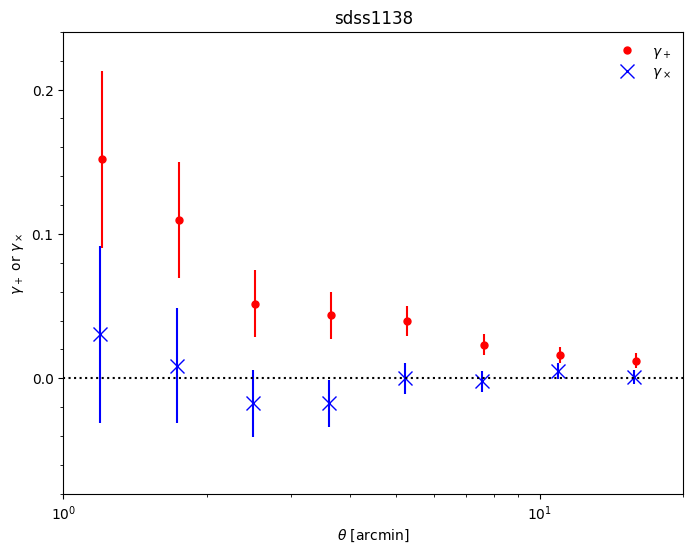

In [67]:
xmin = 1.0
xmax = 20.0
ymin = -0.08
ymax = 0.24

plt.figure(figsize = (8, 6))

plt.plot(tbin * 1.005, gt_ave, '.', markersize = 10, color = 'r')
plt.errorbar(tbin * 1.005, gt_ave, yerr = gt_sig, fmt = 'none', ecolor = 'r', label = '_nolegend_')

plt.plot(tbin * 0.995, gx_ave, 'x', markersize = 10, color = 'b')
plt.errorbar(tbin * 0.995, gx_ave, yerr = gt_sig, fmt = 'none', ecolor = 'b', label = '_nolegend_')

plt.legend(['$\gamma_+$', '$\gamma_\\times$'], markerscale = 1, frameon = False, labelspacing = 0.3, numpoints = 1, loc = 'upper right')

plt.hlines(0, xmin, xmax, linestyles = 'dotted', color = 'black')

ax = plt.gca()
ax.set_xscale('log')

ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.02))

plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

plt.xlabel('$\\theta$ [arcmin]')
plt.ylabel('$\gamma_+$ or $\gamma_\\times$')
plt.title(cname)

It is seen that positive signals of tangential shear ($\gamma_+$) are detected significantly, while cross shear ($\gamma_\times$) is consistent with zero as expected. 

## Fitting

By comparing the observed tangential shear profile with model predictions, one can extract information on the cluster such as the mass. Let's see this by adopting a Singular Isothermal Sphere (SIS) as a specific example. This model is explained in page 43 of [the slides](https://oguri.github.io/lectures/2020ssgc/ssgc2020.pdf).

In [68]:
def fit_sis(x, t_ein):
    return 0.5 * (t_ein / x)

# fit parameter t_ein (Einstein radius) with observed shear profile
tein, cov = curve_fit(fit_sis, tbin, gt_ave, sigma = gt_sig)

print('Einstein radius: %f arcmin' % tein[0])

Einstein radius: 0.352124 arcmin


In [69]:
cov

array([[0.00032294]])

The derived Einstein radius (for the source redshift of $z\sim 1$) of $\sim 30''$ for a1703 seems to be slightly larger than the Einstein radius of $\sim 10''-20''$ from the strong lensing analysis of this cluster (see e.g., [this paper](https://ui.adsabs.harvard.edu/abs/2009ApJ...699.1038O/abstract)). One reason may be that the assumption of the SIS profile is not accurate near the cluster center as we know that the so-called NFW profile described the observed cluster mass distribution better. Anyhow, let's see how good the fitting is by over-plotting the model prediction to the observed tangential shear profile

<>:29: SyntaxWarning: invalid escape sequence '\g'
<>:29: SyntaxWarning: invalid escape sequence '\g'
/var/folders/mp/7xhn2jq112z6td9nlqyw8mvm0000gn/T/ipykernel_67904/3509742283.py:29: SyntaxWarning: invalid escape sequence '\g'
  plt.ylabel('$\gamma_+$')


Text(0.5, 1.0, 'sdss1138')

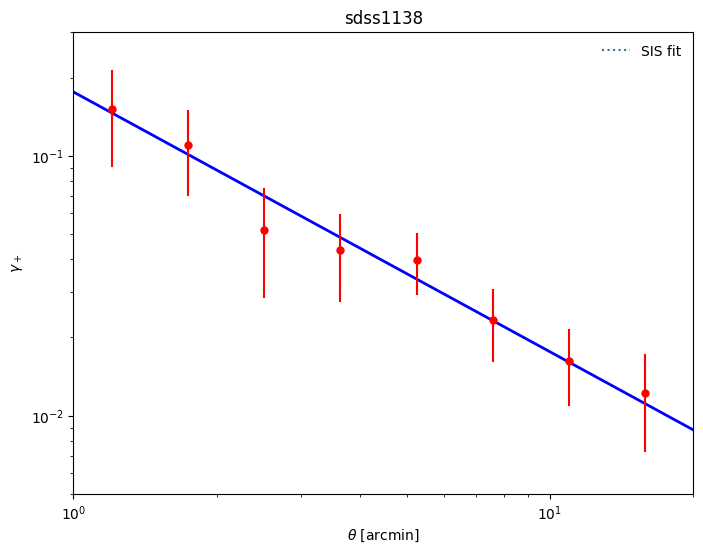

In [70]:
# conpute best-fit profile
tt1 = 10 ** np.linspace(-1.0, 2.0, num = 300)
yy1 = fit_sis(tt1, tein[0])

xmin = 1.0
xmax = 20.0
ymin = 0.005
ymax = 0.3

plt.figure(figsize = (8, 6))

plt.hlines(0, xmin, xmax, linestyles = 'dotted')

plt.plot(tt1, yy1, '-', color = 'b', lw = 2.)

plt.plot(tbin, gt_ave, '.', markersize = 10, color = 'r')
plt.errorbar(tbin, gt_ave, yerr = gt_sig, fmt = 'none', ecolor = 'r', label = '_nolegend_')

plt.legend(['SIS fit'], markerscale = 1, frameon = False, labelspacing = 0.3, numpoints = 1, loc = 'upper right')

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

plt.xlabel('$\\theta$ [arcmin]')
plt.ylabel('$\gamma_+$')
plt.title(cname)

The plot above suggests that fitting is reasonably good.

I can also derive the velocity dispersion from the best-fit Einstein radius, following the definition (page 43 of [the slides](https://oguri.github.io/lectures/2020ssgc/ssgc2020.pdf))

In [71]:
tein_rad = tein[0] * u.arcmin
dos = cosmo.angular_diameter_distance(zs)
dol = cosmo.angular_diameter_distance(zl)
dls = cosmo.angular_diameter_distance_z1z2(zl, zs)
sig = const.c * np.sqrt((tein_rad * dos).to(u.Mpc, u.dimensionless_angles()) / (4.0 * np.pi * dls))

print('velocity dispersion: ', sig.to(u.km/u.s))

velocity dispersion:  1238.4972388334775 km / s


This is consistent with a typical velocity dispersion of massive clusters of galaxies.